C:\Users\William\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'compress']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib
Enter file name: HCB.wav
File length (number of frames): 176640
Frame rate: 44100 Hz
Number of channels: 2
Four bytes per cell
Music data:


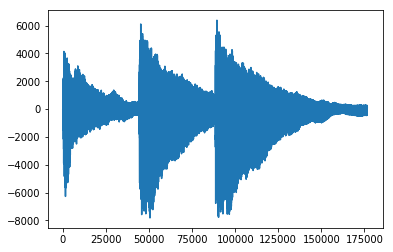

Enter compression factor: 1000
Partitions: [0, 44000, 88000, 176639]


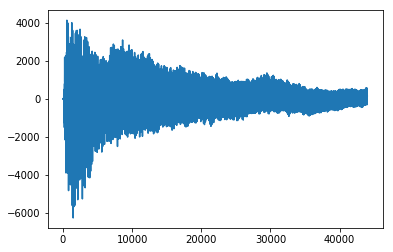

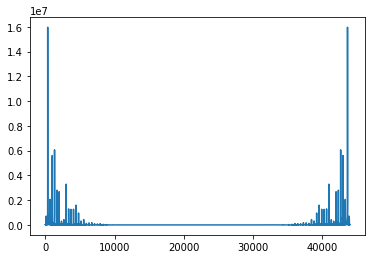

E3


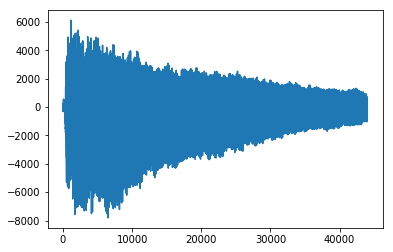

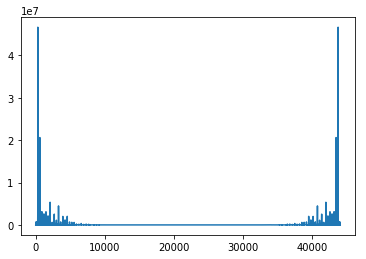

D3


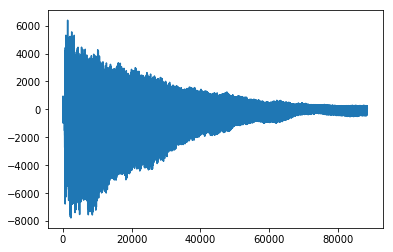

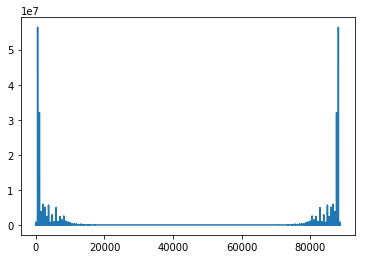

C3


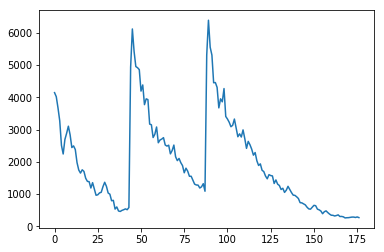

In [4]:
#William Kanieski
#Alex Jonauskas
#Dylan White
#Joel Mueller

%pylab inline

import numpy as np
import math
import wave
import struct
import matplotlib.pyplot as plt

def abs_val(n):
    return n if n >= 0 else -n

def compress(sounds, interval):
    compressed = []
    for i in range(0, len(sounds), interval):
        sub_list = sounds[i:min(i + interval, len(sounds) - 1)]
        compressed.append(max(sub_list))
    return compressed

#Returns the x coordinates of the n highest y values
def n_highest(X, Y, n):
    Z = [(x, y) for x, y in zip(X, Y)]
    Z.sort(reverse=True, key=lambda x: x[1])
    return Z[0:n]

#Tries to partition the audio file based on relative peaks
#Records maximum amplitude A and waits for the amplitude to be less than beta * A
#|\_|\_|\_
#This tells the function to begin looking for a new peak, which should be within
#the interval A * (1 +- alpha)
#Cycle then repeats itself
#Default arguments for alpha and beta were chosen experimentally
#based on multiple audio files
def get_peaks(data, alpha=0.6, beta=0.2):
    peaks = [0]
    reached = False
    low = 1 - beta
    high = 1 + beta
    for i in range(1, len(data)):
        if reached:
            if data[i] < (high * data[peaks[-1]]) and data[i] > (low * data[peaks[-1]]):
                peaks.append(i)
                reached = False
        elif data[i] < alpha * data[peaks[-1]]: reached = True
    return peaks

#Identifies the note based on the peaks in the Fourier transform
def detect_note(f, length, frame_rate, channels):
    #Lists pairing notes with corresponding frequencies for later reference
    notes = np.array(["C0","C#0","D0","D#0","E0","F0","F#0","G0","G#0","A0","A#0","B0","C1","C#1","D1","D#1","E1","F1","F#1","G1","G#1","A1","A#1","B1","C2","C#2","D2","D#2","E2","F2","F#2","G2","G2#","A2","A2#","B2","C3","C3#","D3","D3#","E3","F3","F3#","G3","G3#","A3","A3#","B3","C4","C4#","D4","D4#","E4","F4","F4#","G4","G4#","A4","A4#","B4","C5","C5#","D5","D5#","E5","F5","F5#","G5","G5#","A5","A5#","B5","C6","C6#","D6","D6#","E6","F6","F6#","G6","G6#","A6","A6#","B6","C7","C7#","D7","D7#","E7","F7","F7#","G7","G7#","A7","A7#","B7","C8","C8#","D8","D8#","E8","F8","F8#","G8","G8#","A8","A8#","B8","Beyond B8"])
    frequencies = np.array([16.35,17.32,18.35,19.45,20.60,21.83,23.12,24.50,25.96,27.50,29.14,30.87,32.70,34.65,36.71,38.89,41.20,43.65,46.25,49.00,51.91,55.00,58.27,61.74,65.41,69.30,73.42,77.78,82.41,87.31,92.50,98.00,103.83,110.00,116.54,123.47,130.81,138.59,146.83,155.56,164.81,174.61,185.00,196.00,207.65,220.00,233.08,246.94,261.63,277.18,293.66,311.13,329.63,349.23,369.99,392.00,415.30,440.00,466.16,493.88,523.25,554.37,587.33,622.25,659.26,698.46,739.99,783.99,830.61,880.00,932.33,987.77,1046.50,1108.73,1174.66,1244.51,1318.51,1396.91,1479.98,1567.98,1661.22,1760.00,1864.66,1975.53,2093.00,2217.46,2349.32,2489.02,2637.02,2793.83,2959.96,3135.96,3322.44,3520.00,3729.31,3951.07,4186.01,4434.92,4698.64,4978.03,5274.04,5587.65,5919.91,6271.93,6644.88,7040.00,7458.62,7902.13,8000])
    
    #Find index of the maximum element of the Fourier transform
    max_index = np.argmax(f[0:int(length / 2)])
    #Use it to compute the maximum frequency
    freq = max_index * frame_rate / (len(f) * channels)
    #Try to match frequencies on the interval and pair with a corresponding note
    note_index = -1
    for i in range(0, len(frequencies) - 1):
        if(freq < frequencies[0]):
            note_index = 0
            break
        if(freq > frequencies[-1]):
            note_index = -1
            break
        if freq >= frequencies[i] and frequencies[i + 1] >= freq :
            if freq - frequencies[i] < (frequencies[i + 1] - frequencies[i]) / 2 :
                note_index = i
            else :
                note_index = i + 1
            break
    return notes[note_index]

if __name__ == "__main__":
    #Read input file and get audio file statistics
    file_name = input("Enter file name: ")
    file = wave.open(file_name)
    length = file.getnframes()
    frame_rate = file.getframerate()
    channels = file.getnchannels()
    print("File length (number of frames): {}".format(length))
    print("Frame rate: {} Hz".format(frame_rate))
    print("Number of channels: {}".format(channels))
    
    #Convert file data into list of floating point numbers for FFT
    frame_data = file.readframes(1)
    if len(frame_data) == 2: #Two bytes per cell
        print("Two bytes per cell\n\n\n")
        option = "<h"
        div = float(2**31)
    elif len(frame_data) == 4: #Four bytes per cell
        print("Four bytes per cell")
        option = "<i"
        div = float(2**15)
    sound = [int(struct.unpack(option, frame_data)[0])]
    for i in range(1, length):
        frame_data = file.readframes(1)
        sound.append(int(struct.unpack(option, frame_data)[0]))
    file.close()
    
    sound = np.divide(np.array(sound), div)
    
    #Scale sound and plot results
    #sound = np.divide(sound, div)
    print("Music data:")
    plt.plot(sound)
    plt.show()
    
    #Identify separate notes and partition audio
    compression = int(input("Enter compression factor: "))
    c = compress(sound, compression)
    peaks = get_peaks([i for i in c])
    #Decompress the sound and expand the partitions
    for i in range(len(peaks)): peaks[i] = peaks[i] * compression
    peaks.append(length - 1)
    #Partition the sound
    partitions = [np.array(sound[peaks[i]:peaks[i + 1]]) for i in range(len(peaks) - 1)]
    print("Partitions: {}".format(peaks))
    #Plot the partitions and their Fourier transforms
    #Print out note names
    for p in partitions:
        plt.plot(p)
        plt.show()
        f = np.fft.fft(p)
        f2 = np.absolute(f)
        plt.plot(f2)
        plt.show()
        print(detect_note(f2, length, frame_rate, channels))
    
    #Plot compressed sound
    plt.plot(c)
    plt.show()
    
    

In [20]:
#Experiments

def get_peaks(data, alpha=0.6, beta=0.2):
    peaks = [0]
    max_value = data[0]
    reached = False
    low = 1 - beta
    high = 1 + beta
    for i in range(1, len(data)):
        if reached:
            if data[i] < (high * max_value) and data[i] > (low * max_value):
                peaks.append(i)
                max_value = data[i]
                reached = False
        else:
            if data[i] > max_value: 
                max_value = data[i]
                max_index = i
            elif data[i] < alpha * data[peaks[-1]]: reached = True 
    return peaks

#print(type(c))
#print(type(c[0]))
C = [i[0] for i in c]
print(get_peaks([i[0] for i in c]))

#print(C)

'''
    X = [i for i in range(len(c))]
    partitions = [0] + [p[0] for p in n_highest(X, c, notes - 1)]
    for p in partitions: p *= compression
    print(partitions)
'''


[0, 44, 88]
